# **Importing Modules**

In [ ]:
! pip install -q pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.3 MB/s eta 0:00:00


In [ ]:
# import torch
import numpy as np
import pandas as pd
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.termination import get_termination
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# # Check if GPU is available, otherwise use CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# **Standard Lake Problem**

In [ ]:
class LakeProblem(ElementwiseProblem):

  def __init__(self, n_years=100, delta=0.98):
      super().__init__(n_var=n_years, n_obj=2, n_constr=0, xl=0.0, xu=1)
      self.n_years = n_years
      self.b = 0.42
      self.q = 2.00
      self.alpha_o = 0.4
      self.beta_1 = 0.08
      self.delta = delta

  def _evaluate(self, a, out, *args, **kwargs):
      # a: Anthropogenic pollution over time

      # Initialize the phosphorus concentration
      X = np.zeros(self.n_years)
      X[0] = 0.01  # Initial phosphorus concentration

      # Simulate phosphorus dynamics over time
      for t in range(self.n_years - 1):
          X[t+1] = X[t] - self.b * X[t] + (X[t]**self.q) / (1 + X[t]**self.q) + a[t]

      # Objective 1: Minimize mean phosphorus concentration (FE)
      mean_phosphorus_concentration = np.mean(X)

      # Objective 2: Maximize the net present value of utility (FV), but we minimize -FV for consistency
      utility = np.zeros(self.n_years)
      for t in range(self.n_years):
          utility[t] = self.alpha_o * a[t] - self.beta_1 * X[t]**2

      # Net present value of utility with discount factor
      net_present_value_utility = np.sum([self.delta**t * utility[t] for t in range(self.n_years)])

      # Set objectives: minimize phosphorus concentration, maximize utility
      out["F"] = [ -net_present_value_utility, mean_phosphorus_concentration]


In [ ]:
# Define the optimization problem
n_years = 100  # Number of years to simulate
problem = LakeProblem(n_years=n_years)

In [ ]:
# Reference directions for decomposition (weights for the subproblems)
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=100)

# **MOEA/D Algorithm on Standard Lake Problem**

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      101 |      1 |             - |             -
     2 |      202 |     15 |  2.5084162578 |         ideal
     3 |      303 |     59 |  2.393903E+01 |         ideal
     4 |      404 |     31 |  1.865286E+01 |         ideal
     5 |      505 |     30 |  1.998613E+01 |         ideal
     6 |      606 |     15 |  0.2960717225 |         ideal
     7 |      707 |     15 |  0.1666387217 |         ideal
     8 |      808 |     15 |  0.2583893608 |         ideal
     9 |      909 |     15 |  0.7446251172 |         ideal
    10 |     1010 |     15 |  0.3875060541 |         ideal
    11 |     1111 |     20 |  0.1936039672 |         ideal
    12 |     1212 |     15 |  0.2868802457 |         ideal
    13 |     1313 |     15 |  0.1792001021 |         ideal
    14 |     1414 |     33 |  3.796256E+01 |         ideal
    15 |     1515 |     30 |  1.118203E+01 |         ideal
    16 |     1616 |     15 |  0.2471426730 |         ide

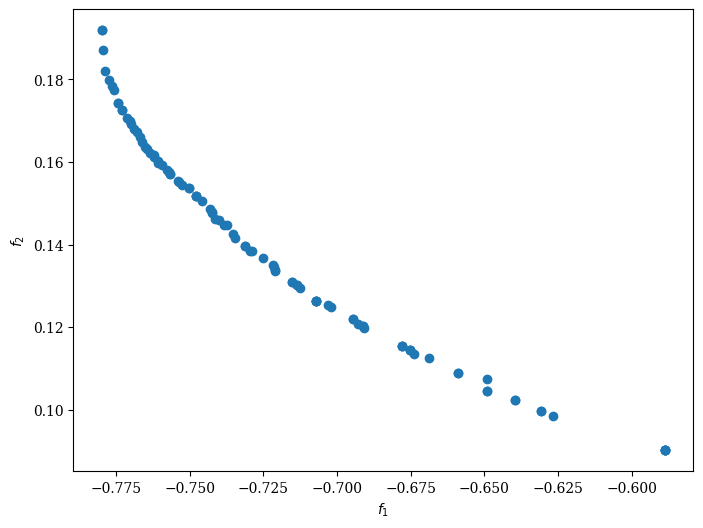

In [ ]:
# MOEA/D Algorithm
algorithm = MOEAD(
    ref_dirs=ref_dirs,
    n_neighbors=15,  # Number of neighboring subproblems
    prob_neighbor_mating=0.7,  # Probability of mating within neighbors
)

# Termination criterio  n (number of generations)
termination = get_termination("n_gen", 200)

# Solve the problem
res_MOEAD = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# Plot the Pareto front
Scatter().add(res_MOEAD.F).show()

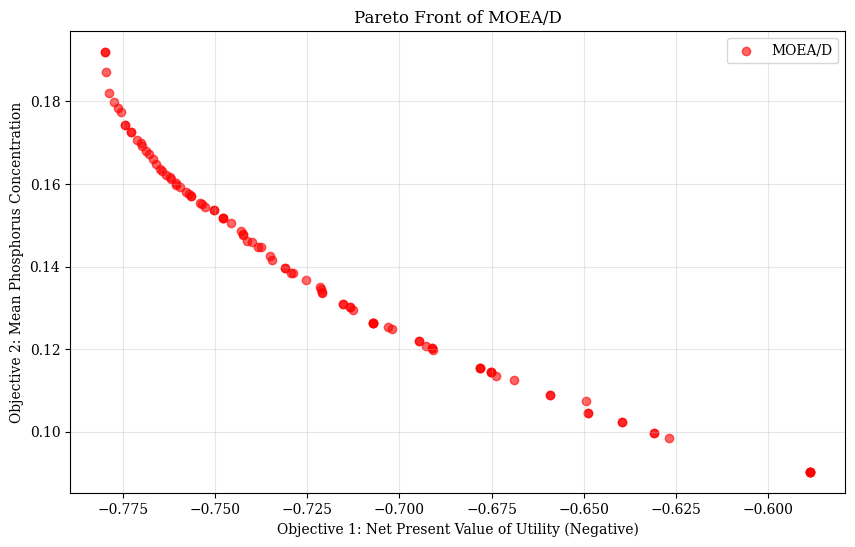

In [ ]:
# Create a scatter plot for the MOEA/D results
plt.figure(figsize=(10, 6))

# Plot MOEA/D results
plt.scatter(res_MOEAD.F[:, 0], res_MOEAD.F[:, 1], label="MOEA/D", color='red', alpha=0.6)

# Customize the plot with labels, axis labels, title, and grid
plt.title("Pareto Front of MOEA/D")
plt.xlabel("Objective 1: Net Present Value of Utility (Negative)")
plt.ylabel("Objective 2: Mean Phosphorus Concentration")
plt.legend()  # Display the legend for MOEA/D
plt.grid(True, alpha=0.3)  # Add a faint grid with alpha for transparency

# Show the combined scatter plot
plt.show()


# **NSGA-II Algorithm on Standard Lake Problem**

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      1 |  0.000000E+00 |             f
     3 |      300 |      2 |  1.0000000000 |         ideal
     4 |      400 |      1 |  0.9065088983 |         ideal
     5 |      500 |      1 |  0.000000E+00 |             f
     6 |      600 |      1 |  0.7709518193 |         ideal
     7 |      700 |      2 |  2.0876971041 |         ideal
     8 |      800 |      1 |  0.2570271990 |         ideal
     9 |      900 |      1 |  0.9363837356 |         ideal
    10 |     1000 |      1 |  0.6139915848 |         ideal
    11 |     1100 |      1 |  1.5183444363 |         ideal
    12 |     1200 |      1 |  0.2692786374 |         ideal
    13 |     1300 |      1 |  0.000000E+00 |             f
    14 |     1400 |      4 |  1.4551197400 |         ideal
    15 |     1500 |      3 |  4.2164348528 |         ideal
    16 |     1600 |      1 |  0.9537112222 |         ide

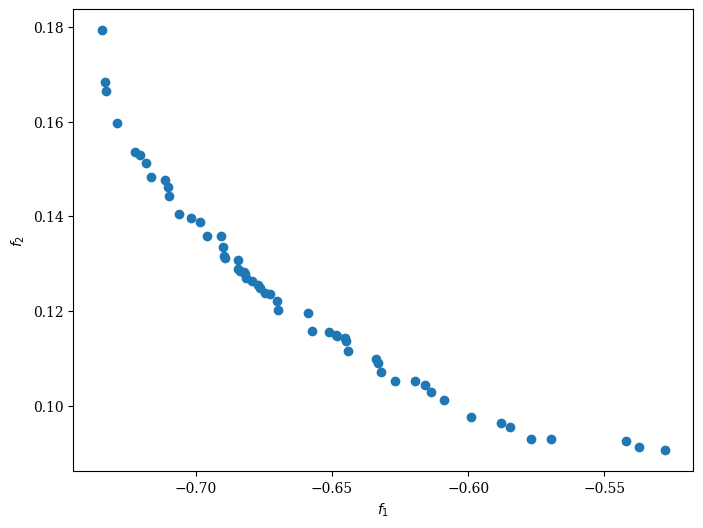

In [ ]:
# NSGA-II Algorithm
algorithm = NSGA2(pop_size=100)

# Termination criterion (we stop after a certain number of generations)
termination = get_termination("n_gen", 200)

# Solve the problem
res_NSGA2 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# Plot the Pareto front
Scatter().add(res_NSGA2.F).show()

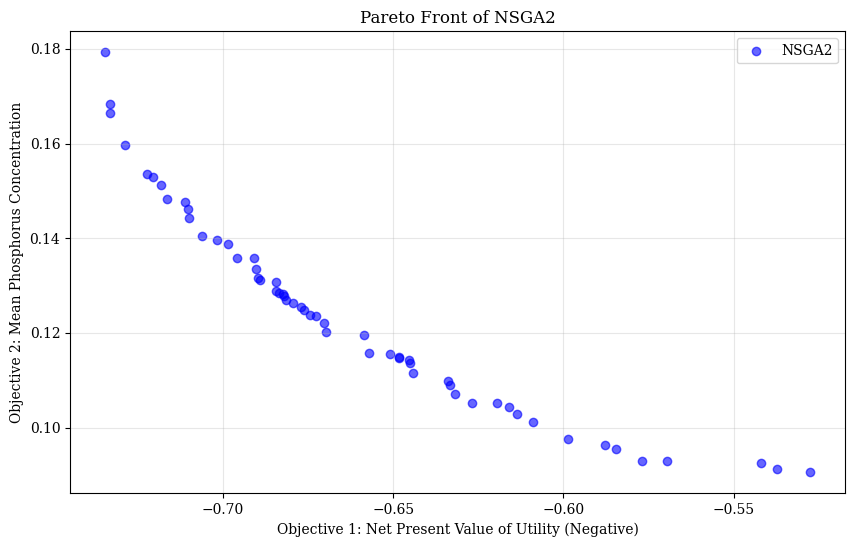

In [ ]:
# Create a scatter plot for the MOEA/D results
plt.figure(figsize=(10, 6))

# Plot MOEA/D results
plt.scatter(res_NSGA2.F[:, 0], res_NSGA2.F[:, 1], label="NSGA2", color='blue', alpha=0.6)

# Customize the plot with labels, axis labels, title, and grid
plt.title("Pareto Front of NSGA2")
plt.xlabel("Objective 1: Net Present Value of Utility (Negative)")
plt.ylabel("Objective 2: Mean Phosphorus Concentration")
plt.legend()  # Display the legend for MOEA/D
plt.grid(True, alpha=0.3)  # Add a faint grid with alpha for transparency

# Show the combined scatter plot
plt.show()


# **Comaparison of Algorithms for Standard Lake Problem**

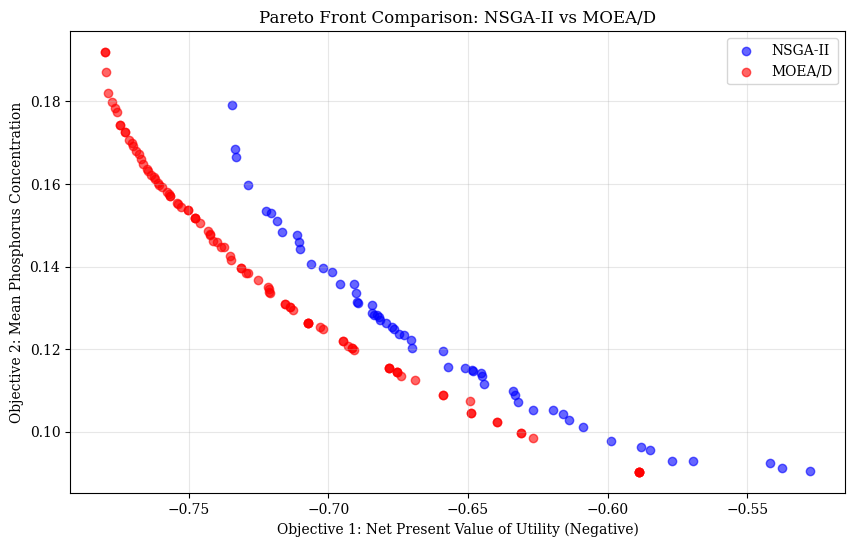

In [ ]:
# Create a scatter plot for both NSGA-II and MOEA/D results
plt.figure(figsize=(10, 6))

# Plot NSGA-II results
plt.scatter(res_NSGA2.F[:, 0], res_NSGA2.F[:, 1], label="NSGA-II", color='blue', alpha=0.6)

# Plot MOEA/D results
plt.scatter(res_MOEAD.F[:, 0], res_MOEAD.F[:, 1], label="MOEA/D", color='red', alpha=0.6)

# Customize the plot with labels, axis labels, title, and grid
plt.title("Pareto Front Comparison: NSGA-II vs MOEA/D")
plt.xlabel("Objective 1: Net Present Value of Utility (Negative)")
plt.ylabel("Objective 2: Mean Phosphorus Concentration")
plt.legend()  # Display the legend for NSGA-II and MOEA/D
plt.grid(True, alpha=0.3)  # Add a faint grid with alpha for transparency

# Show the combined scatter plot
plt.show()

In [ ]:
df = pd.DataFrame(res_MOEAD.F, columns=['Objective 1', 'Objective 2'])
df.to_csv('results_MOEAD.csv', index=False)

df_decisions = pd.DataFrame(res_MOEAD.X, columns=[f'Decision Variable {i+1}' for i in range(res_MOEAD.X.shape[1])])
df_decisions.to_csv('decision_variables_MOEAD.csv', index=False)

In [ ]:
df = pd.DataFrame(res_NSGA2.F, columns=['Objective 1', 'Objective 2'])
df.to_csv('results_NSGA2.csv', index=False)

df_decisions = pd.DataFrame(res_NSGA2.X, columns=[f'Decision Variable {i+1}' for i in range(res_NSGA2.X.shape[1])])
df_decisions.to_csv('decision_variables_NSGA2.csv', index=False)

# **Lake Problem with Monte Carlo uncertainty**

In [ ]:
# # Define the modified lake problem with multi-objective optimization and Monte Carlo uncertainty
# class LakeProblem_uncertanity(ElementwiseProblem):

#     def __init__(self, n_years=100, delta=0.98, num_samples=1000):
#         super().__init__(n_var=n_years, n_obj=2, n_constr=0, xl=0.0, xu=1)
#         self.n_years = n_years
#         self.b = 0.42
#         self.q = 2.00
#         self.alpha_o = 0.4
#         self.beta_1 = 0.08
#         self.delta = delta
#         self.num_samples = num_samples  # Number of Monte Carlo samples

#     def _evaluate(self, a, out, *args, **kwargs):
#         # a: Anthropogenic pollution over time

#         # Initialize arrays to store results
#         phosphorus_concentrations = np.zeros(self.num_samples)
#         net_present_values = np.zeros(self.num_samples)

#         for i in range(self.num_samples):
#             # Initialize the phosphorus concentration
#             X = np.zeros(self.n_years)
#             X[0] = 0.01  # Initial phosphorus concentration

#             # Simulate phosphorus dynamics over time
#             for t in range(self.n_years-1):
#                 # Add random noise to the phosphorus dynamics
#                 noise = np.random.normal(0, 0.05)  # Adjust the standard deviation as needed
#                 X[t+1] = X[t] - self.b * X[t] + (X[t]**self.q) / (1 + X[t]**self.q) + a[t] + noise

#             # Objective 1: Minimize mean phosphorus concentration (FE) with uncertainty
#             phosphorus_concentrations[i] = np.mean(X)

#             # Objective 2: Maximize the net present value of utility (FV) with uncertainty
#             utility = np.zeros(self.n_years)
#             for t in range(self.n_years):
#                 utility[t] = self.alpha_o * a[t] - self.beta_1 * X[t]**2

#             # Net present value of utility with discount factor
#             net_present_value_utility = np.sum([self.delta**t * utility[t] for t in range(self.n_years)])

#             # Store the net present value of utility
#             net_present_values[i] = net_present_value_utility

#         # Set objectives: minimize mean phosphorus concentration, maximize utility
#         out["F"] = [np.mean(phosphorus_concentrations), -np.mean(net_present_values)]


In [ ]:
# Define the modified lake problem with multi-objective optimization and Monte Carlo uncertainty
class LakeProblem_uncertainty(ElementwiseProblem):

    def __init__(self, n_years=100, delta=0.98, num_samples=1000):
        super().__init__(n_var=n_years, n_obj=2, n_constr=0, xl=0.0, xu=1)
        self.n_years = n_years
        self.b = 0.42
        self.q = 2.00
        self.alpha_o = 0.4
        self.beta_1 = 0.08
        self.delta = delta
        self.num_samples = num_samples  # Number of Monte Carlo samples

    def _evaluate(self, a, out, *args, **kwargs):
        # a:

        # Initialize array to store the average phosphorus concentration
        avg_phosphorus_concentrations = np.zeros(self.num_samples)

        # Simulate the phosphorus dynamics for N = num_samples (Monte Carlo uncertainty)
        for i in range(self.num_samples):
            # Initialize phosphorus concentration for each sample
            X = np.zeros(self.n_years)
            X[0] = 0.01  # Initial phosphorus concentration

            # Generate log-normal noise for stochastic simulation (epsilon)
            epsilon = np.random.lognormal(mean=np.log(0.02), sigma=0.02, size=self.n_years)

            # Simulate phosphorus dynamics over time
            for t in range(self.n_years - 1):
                X[t+1] = X[t] - self.b * X[t] + (X[t]**self.q) / (1 + X[t]**self.q) + a[t] + epsilon[t]

            # Compute mean phosphorus concentration for this simulation run
            avg_phosphorus_concentrations[i] = np.mean(X)

        # Objective 1: Minimize the mean of average phosphorus concentration across all samples
        mean_phosphorus_concentration = np.mean(avg_phosphorus_concentrations)

        # Objective 2: Maximize the net present value of utility, calculated once (not per sample)
        utility = np.zeros(self.n_years)
        for t in range(self.n_years):
            utility[t] = self.alpha_o * a[t] - self.beta_1 * (X[t] ** 2)

        # Compute the net present value of utility using the discount factor
        net_present_value_utility = np.sum([self.delta**t * utility[t] for t in range(self.n_years)])

        # Set objectives: minimize mean phosphorus concentration, maximize discounted utility
        # To align with minimizing objectives in optimization, negate the net present value (for maximization)
        out["F"] = [-net_present_value_utility, mean_phosphorus_concentration]

In [ ]:
# Define the optimization problem
n_years = 100  # Number of years to simulate
problem = LakeProblem_uncertainty(n_years=n_years)

In [ ]:
# Reference directions for decomposition (weights for the subproblems)
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=100)

# **MOEA/D Algorithm for Lake problem with Monte Carlo uncertainty**

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      101 |      1 |             - |             -
     2 |      202 |     15 |  0.6661556934 |         ideal
     3 |      303 |     15 |  1.2928098350 |         ideal
     4 |      404 |     30 |  9.172322E+02 |         ideal
     5 |      505 |     28 |  1.467188E+03 |         ideal
     6 |      606 |     15 |  0.2234742981 |         ideal
     7 |      707 |     15 |  0.3904138968 |         ideal
     8 |      808 |     24 |  4.6192659075 |         ideal
     9 |      909 |     24 |  2.953907E+01 |         ideal
    10 |     1010 |     25 |  1.961637E+03 |         ideal
    11 |     1111 |     15 |  0.1866514541 |         ideal
    12 |     1212 |     15 |  0.1090628308 |         ideal
    13 |     1313 |     17 |  2.818362E+02 |         ideal
    14 |     1414 |     15 |  0.2005720470 |         ideal
    15 |     1515 |     15 |  0.2694662605 |         ideal
    16 |     1616 |     30 |  1.671856E+01 |         ide

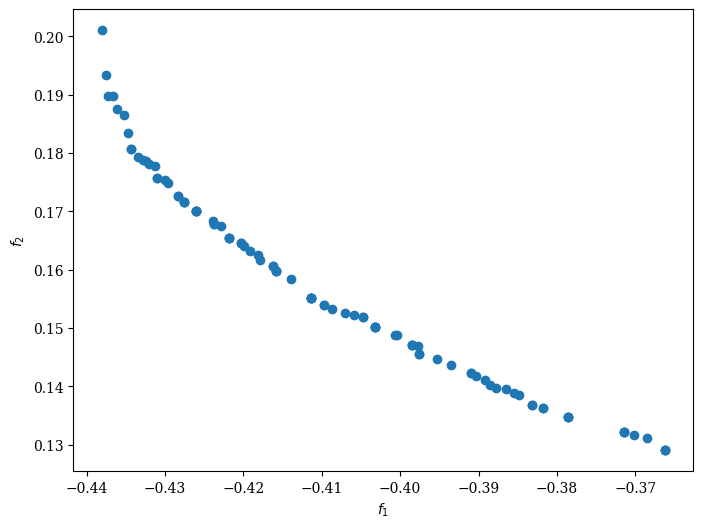

In [ ]:
# MOEA/D Algorithm
algorithm = MOEAD(
    ref_dirs=ref_dirs,
    n_neighbors=15,  # Number of neighboring subproblems
    prob_neighbor_mating=0.7,  # Probability of mating within neighbors
)

# Termination criterion (number of generations)
termination = get_termination("n_gen", 200)

# Solve the problem
res_MOEAD_u = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# Plot the Pareto front
Scatter().add(res_MOEAD_u.F).show()

In [ ]:
df = pd.DataFrame(res_MOEAD_u.F, columns=['Objective 1', 'Objective 2'])
df.to_csv('results_MOEAD_u.csv', index=False)

df_decisions = pd.DataFrame(res_MOEAD_u.X, columns=[f'Decision Variable {i+1}' for i in range(res_MOEAD_u.X.shape[1])])
df_decisions.to_csv('decision_variables_MOEAD_u.csv', index=False)

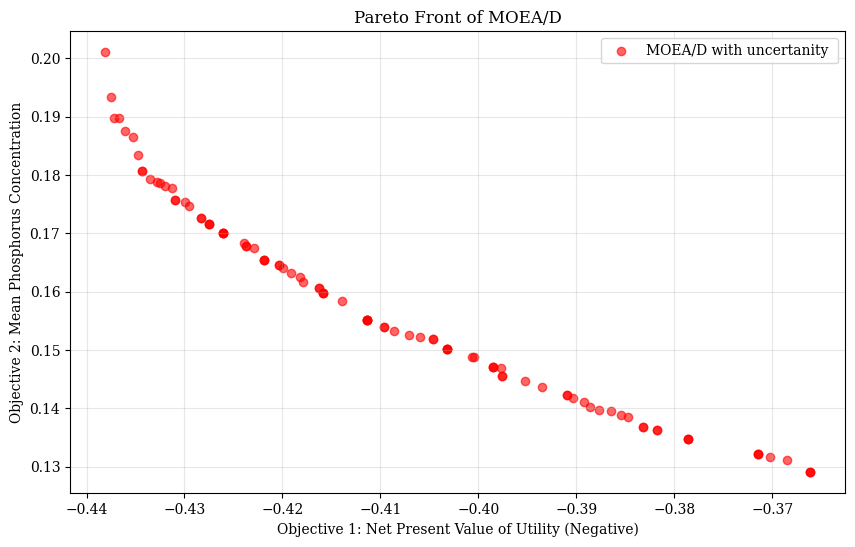

In [ ]:
# Create a scatter plot for the MOEA/D results
plt.figure(figsize=(10, 6))

# Plot MOEA/D results
plt.scatter(res_MOEAD_u.F[:, 0], res_MOEAD_u.F[:, 1], label="MOEA/D with uncertanity ", color='red', alpha=0.6)

# Customize the plot with labels, axis labels, title, and grid
plt.title("Pareto Front of MOEA/D")
plt.xlabel("Objective 1: Net Present Value of Utility (Negative)")
plt.ylabel("Objective 2: Mean Phosphorus Concentration")
plt.legend()  # Display the legend for MOEA/D
plt.grid(True, alpha=0.3)  # Add a faint grid with alpha for transparency

# Show the combined scatter plot
plt.show()


# **NSGA-II Algorithm for Lake problem with Monte Carlo uncertainty 200 gen**

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      2 |  1.0000000000 |         ideal
     3 |      300 |      2 |  0.000000E+00 |             f
     4 |      400 |      2 |  0.5136937219 |         ideal
     5 |      500 |      2 |  4.8221576783 |         ideal
     6 |      600 |      1 |  0.8207335745 |         ideal
     7 |      700 |      1 |  0.3204393662 |         ideal
     8 |      800 |      2 |  8.361277E+01 |         ideal
     9 |      900 |      3 |  1.2871551595 |         ideal
    10 |     1000 |      1 |  0.6696226482 |         ideal
    11 |     1100 |      4 |  3.3169903509 |         ideal
    12 |     1200 |      1 |  0.8609820664 |         ideal
    13 |     1300 |      1 |  0.0254746570 |         ideal
    14 |     1400 |      1 |  0.5872782710 |         ideal
    15 |     1500 |      2 |  8.3006834644 |         ideal
    16 |     1600 |      2 |  1.7333293637 |         ide

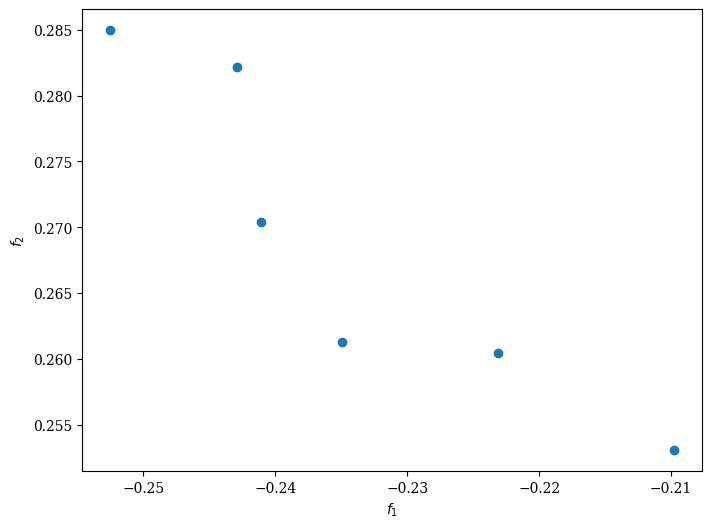

In [ ]:
# NSGA-II Algorithm
algorithm = NSGA2(pop_size=100)

# Termination criterion (we stop after a certain number of generations)
termination = get_termination("n_gen", 200)

# Solve the problem
res_NSGA2_u = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# Plot the Pareto front
Scatter().add(res_NSGA2_u.F).show()


In [ ]:
df = pd.DataFrame(res_NSGA2_u.F, columns=['Objective 1', 'Objective 2'])
df.to_csv('results_NSGA2_u.csv', index=False)

df_decisions = pd.DataFrame(res_NSGA2_u.X, columns=[f'Decision Variable {i+1}' for i in range(res_NSGA2_u.X.shape[1])])
df_decisions.to_csv('decision_variables_NSGA2_u.csv', index=False)

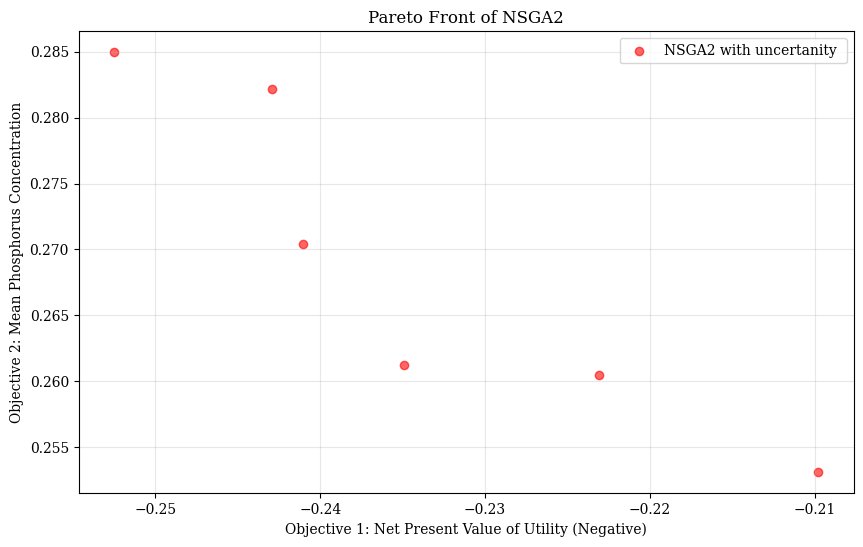

In [ ]:
# Create a scatter plot for the MOEA/D results
plt.figure(figsize=(10, 6))

# Plot MOEA/D results
plt.scatter(res_NSGA2_u.F[:, 0], res_NSGA2_u.F[:, 1], label="NSGA2 with uncertanity ", color='red', alpha=0.6)

# Customize the plot with labels, axis labels, title, and grid
plt.title("Pareto Front of NSGA2")
plt.xlabel("Objective 1: Net Present Value of Utility (Negative)")
plt.ylabel("Objective 2: Mean Phosphorus Concentration")
plt.legend()  # Display the legend for MOEA/D
plt.grid(True, alpha=0.3)  # Add a faint grid with alpha for transparency

# Show the combined scatter plot
plt.show()

# **Comaparison of Algorithms for Lake Problem with Monte Carlo uncertainty 200 gen**

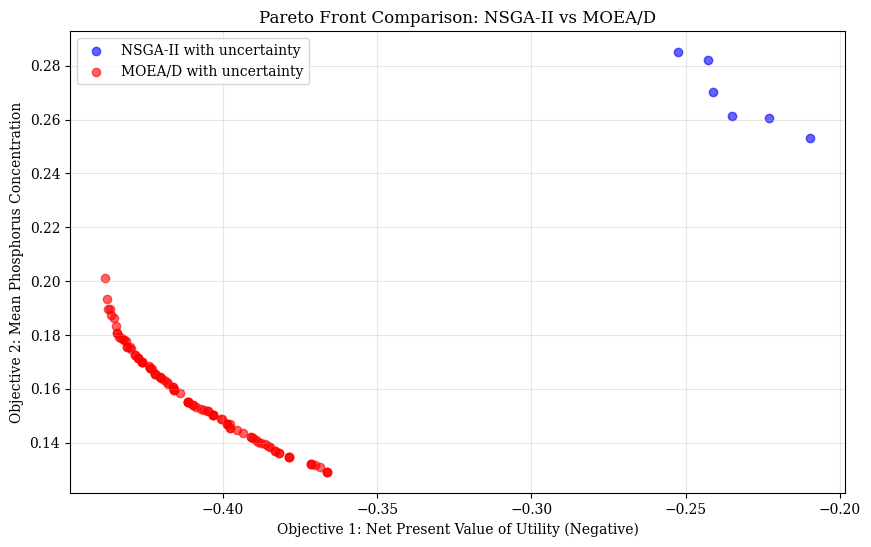

In [ ]:
# Create a scatter plot for both NSGA-II and MOEA/D results
plt.figure(figsize=(10, 6))

# Plot NSGA-II results
plt.scatter(res_NSGA2_u.F[:, 0], res_NSGA2_u.F[:, 1], label="NSGA-II with uncertainty", color='blue', alpha=0.6)

# Plot MOEA/D results
plt.scatter(res_MOEAD_u.F[:, 0], res_MOEAD_u.F[:, 1], label="MOEA/D with uncertainty", color='red', alpha=0.6)

# Customize the plot with labels, axis labels, title, and grid
plt.title("Pareto Front Comparison: NSGA-II vs MOEA/D")
plt.xlabel("Objective 1: Net Present Value of Utility (Negative)")
plt.ylabel("Objective 2: Mean Phosphorus Concentration")
plt.legend()  # Display the legend for NSGA-II and MOEA/D
plt.grid(True, alpha=0.3)  # Add a faint grid with alpha for transparency

# Show the combined scatter plot
plt.show()

# **Comparison of all algorithms 200 gen**

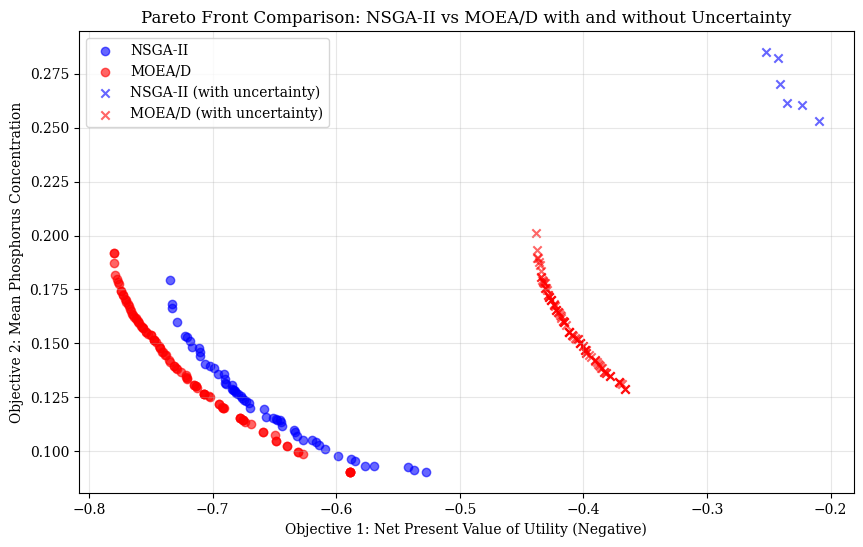

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot for both NSGA-II, MOEA/D and their uncertainty versions
plt.figure(figsize=(10, 6))

# Plot NSGA-II results
plt.scatter(res_NSGA2.F[:, 0], res_NSGA2.F[:, 1], label="NSGA-II", color='blue', alpha=0.6, marker='o')

# Plot MOEA/D results
plt.scatter(res_MOEAD.F[:, 0], res_MOEAD.F[:, 1], label="MOEA/D", color='red', alpha=0.6, marker='o')

# Plot NSGA-II results with uncertainty
plt.scatter(res_NSGA2_u.F[:, 0], res_NSGA2_u.F[:, 1], label="NSGA-II (with uncertainty)", color='blue', alpha=0.6, marker='x')

# Plot MOEA/D results with uncertainty
plt.scatter(res_MOEAD_u.F[:, 0], res_MOEAD_u.F[:, 1], label="MOEA/D (with uncertainty)", color='red', alpha=0.6, marker='x')

# Customize the plot with labels, axis labels, title, and grid
plt.title("Pareto Front Comparison: NSGA-II vs MOEA/D with and without Uncertainty")
plt.xlabel("Objective 1: Net Present Value of Utility (Negative)")
plt.ylabel("Objective 2: Mean Phosphorus Concentration")
plt.legend()  # Display the legend for all methods
plt.grid(True, alpha=0.3)  # Add a faint grid with alpha for transparency

# Show the combined scatter plot
plt.show()


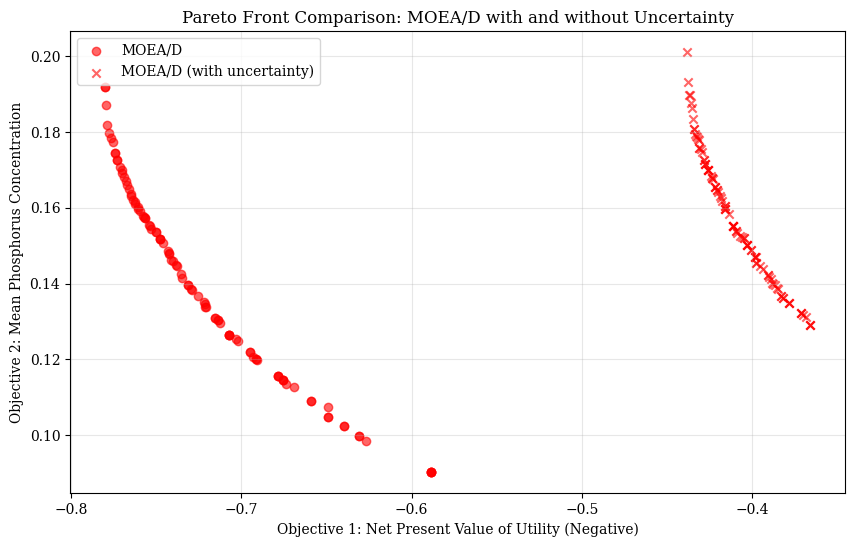

In [ ]:
# Create a scatter plot for MOEA/D and its uncertainty version
plt.figure(figsize=(10, 6))

# Plot MOEA/D results
plt.scatter(res_MOEAD.F[:, 0], res_MOEAD.F[:, 1], label="MOEA/D", color='red', alpha=0.6, marker='o')

# Plot MOEA/D results with uncertainty
plt.scatter(res_MOEAD_u.F[:, 0], res_MOEAD_u.F[:, 1], label="MOEA/D (with uncertainty)", color='red', alpha=0.6, marker='x')

# Customize the plot with labels, axis labels, title, and grid
plt.title("Pareto Front Comparison: MOEA/D with and without Uncertainty")
plt.xlabel("Objective 1: Net Present Value of Utility (Negative)")
plt.ylabel("Objective 2: Mean Phosphorus Concentration")
plt.legend()  # Display the legend for both methods
plt.grid(True, alpha=0.3)  # Add a faint grid with alpha for transparency

# Show the scatter plot
plt.show()


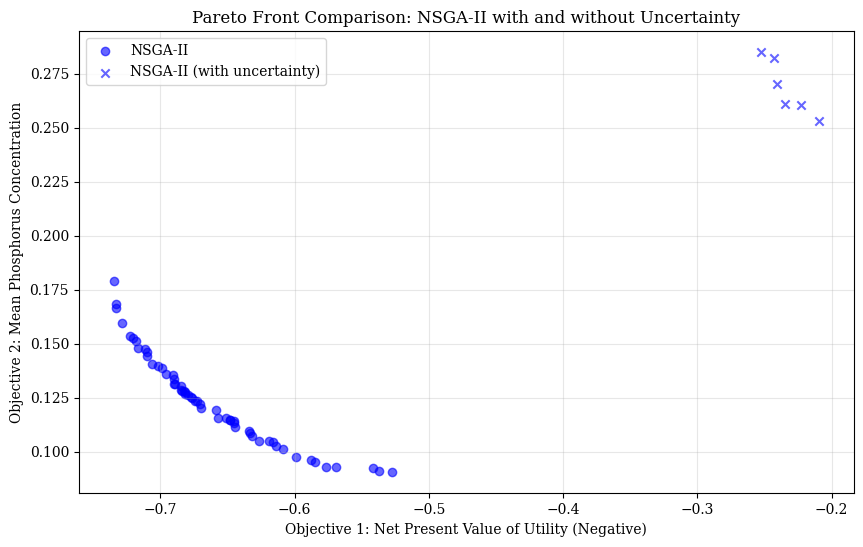

In [ ]:
# Create a scatter plot for NSGA-II and its uncertainty version
plt.figure(figsize=(10, 6))

# Plot NSGA-II results
plt.scatter(res_NSGA2.F[:, 0], res_NSGA2.F[:, 1], label="NSGA-II", color='blue', alpha=0.6, marker='o')

# Plot NSGA-II results with uncertainty
plt.scatter(res_NSGA2_u.F[:, 0], res_NSGA2_u.F[:, 1], label="NSGA-II (with uncertainty)", color='blue', alpha=0.6, marker='x')

# Customize the plot with labels, axis labels, title, and grid
plt.title("Pareto Front Comparison: NSGA-II with and without Uncertainty")
plt.xlabel("Objective 1: Net Present Value of Utility (Negative)")
plt.ylabel("Objective 2: Mean Phosphorus Concentration")
plt.legend()  # Display the legend for both methods
plt.grid(True, alpha=0.3)  # Add a faint grid with alpha for transparency

# Show the scatter plot
plt.show()


# **NSGA2 500 gen**

In [ ]:
# Define the optimization problem
n_years = 100  # Number of years to simulate
problem = LakeProblem_uncertainty(n_years=n_years)

# NSGA-II Algorithm
algorithm = NSGA2(pop_size=200)

# Termination criterion (we stop after a certain number of generations)
termination = get_termination("n_gen", 500)

# Solve the problem
res_NSGA2_u_trial = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# Plot the Pareto front
Scatter().add(res_NSGA2_u.F).show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      1 |             - |             -
     2 |      400 |      1 |  0.000000E+00 |             f
     3 |      600 |      2 |  9.2052421119 |         ideal
     4 |      800 |      5 |  0.3847916121 |         ideal
     5 |     1000 |      3 |  2.0718870967 |         ideal
     6 |     1200 |      2 |  4.7419216417 |         ideal
     7 |     1400 |      2 |  3.2109365127 |         ideal
     8 |     1600 |      2 |  6.4145399704 |         ideal
     9 |     1800 |      3 |  2.2877621532 |         ideal
    10 |     2000 |      1 |  1.6672310426 |         ideal
    11 |     2200 |      1 |  0.0638303008 |         ideal
    12 |     2400 |      3 |  4.2843291263 |         ideal
    13 |     2600 |      1 |  0.9386169469 |         ideal
    14 |     2800 |      1 |  0.5144949962 |         ideal
    15 |     3000 |      1 |  0.000000E+00 |             f
    16 |     3200 |      2 |  2.4013715262 |         ide

NameError: name 'res_NSGA2_u' is not defined

In [ ]:
df = pd.DataFrame(res_NSGA2_u_trial.F, columns=['Objective 1', 'Objective 2'])
df.to_csv('results_NSGA2_u_trial.csv', index=False)

df_decisions = pd.DataFrame(res_NSGA2_u_trial.X, columns=[f'Decision Variable {i+1}' for i in range(res_NSGA2_u_trial.X.shape[1])])
df_decisions.to_csv('decision_variables_NSGA2_u_trial.csv', index=False)

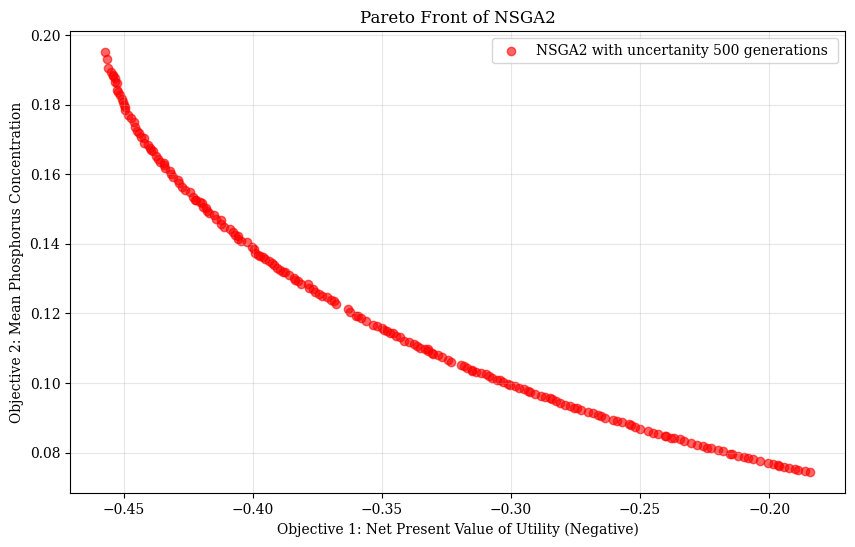

In [ ]:
# Create a scatter plot for the MOEA/D results
plt.figure(figsize=(10, 6))

# Plot MOEA/D results
plt.scatter(res_NSGA2_u_trial.F[:, 0], res_NSGA2_u_trial.F[:, 1], label="NSGA2 with uncertanity 500 generations ", color='red', alpha=0.6)

# Customize the plot with labels, axis labels, title, and grid
plt.title("Pareto Front of NSGA2")
plt.xlabel("Objective 1: Net Present Value of Utility (Negative)")
plt.ylabel("Objective 2: Mean Phosphorus Concentration")
plt.legend()  # Display the legend for MOEA/D
plt.grid(True, alpha=0.3)  # Add a faint grid with alpha for transparency

# Show the combined scatter plot
plt.show()